<a href="https://colab.research.google.com/github/iyibaba3498/iyi-Iot-implementation/blob/main/dual_gi_detection_notebook_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
from PIL import Image
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix


random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


# New Section

### Helper Functions

In [1]:
def plot_sample_images(data_gen, title):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    for i in range(8):
        img, label = data_gen.__next__()
        axes[i].imshow(img[0])
        axes[i].set_title(f"{title}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

def plot_random_images(data_dir, n_images=8):
    # Get all classes (folders)
    classes = os.listdir(data_dir)

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        # Randomly select a class
        class_name = random.choice(classes)
        class_path = os.path.join(data_dir, class_name)

        # Randomly select an image from this class
        image_name = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, image_name)

        # Load and display image
        image = Image.open(image_path)
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Class: {class_name}')

    plt.tight_layout()
    plt.show()


def plot_training(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    ax[0].legend()
    ax[0].set_title("Model Accuracy")
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Val Loss')
    ax[1].legend()
    ax[1].set_title("Model Loss")

    plt.show()

def generate_gradcam(img_path, model, last_conv_layer_name, pred_index=None):
    """
    Generates Grad-CAM heatmap for a given image and model.

    Parameters:
        img_path (str): Path to the input image.
        model (tf.keras.Model): Trained model.
        last_conv_layer_name (str): Name of the last convolutional layer.
        pred_index (int): Index of the class to visualize. Default is the model's top predicted class.

    Returns:
        heatmap (np.array): Grad-CAM heatmap.
    """

    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = np.argmax(predictions[0])  # Get predicted class
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = np.dot(conv_outputs, pooled_grads.numpy().reshape(-1, 1)).squeeze()

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def overlay_gradcam(img_path, heatmap, alpha=0.5):
    """
    Overlays Grad-CAM heatmap on original image.

    Parameters:
        img_path (str): Path to the input image.
        heatmap (np.array): Generated Grad-CAM heatmap.
        alpha (float): Opacity level for overlay.

    Returns:
        Superimposed Grad-CAM image.
    """
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (299, 299))

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()


# New Section

###### DATA:
######Download and unzip the Hyper-Kvasir dataset.
######Display class names and number of images per class.
######Create a training-validation split (20% validation).
######Apply image augmentation using ImageDataGenerator.
######Display sample images to verify dataset loading.
###### Download and extract dataset


In [ ]:
!wget https://datasets.simula.no/downloads/kvasir/kvasir-dataset-v2.zip
!unzip -q kvasir-dataset-v2.zip -d kvasir-dataset

data_dir = "kvasir-dataset/kvasir-dataset-v2"
validation_split = 0.2
random_seed = 42

class_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
print(f" Dataset contains {len(class_names)} classes: {class_names}")

val_dir = "validation"
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
    for class_name in class_names:
        os.makedirs(os.path.join(val_dir, class_name))

random.seed(random_seed)
for class_name in class_names:
    source_dir = os.path.join(data_dir, class_name)
    dest_dir = os.path.join(val_dir, class_name)
    image_files = os.listdir(source_dir)
    random.shuffle(image_files)

    num_val_samples = int(len(image_files) * validation_split)
    val_files = image_files[:num_val_samples]

    for file in val_files:
        source_path = os.path.join(source_dir, file)
        dest_path = os.path.join(dest_dir, file)
        shutil.move(source_path, dest_path)


--2025-06-27 12:22:14--  https://datasets.simula.no/downloads/kvasir/kvasir-dataset-v2.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2489312085 (2.3G) [application/zip]
Saving to: ‘kvasir-dataset-v2.zip’

kvasir-dataset-v2.z 100%[===================>]   2.32G  24.6MB/s    in 81s     

2025-06-27 12:23:36 (29.2 MB/s) - ‘kvasir-dataset-v2.zip’ saved [2489312085/2489312085]



NameError: name 'os' is not defined

In [ ]:
train_gen = train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Reduced from 40
    width_shift_range=0.1,  # Reduced from 0.2
    height_shift_range=0.1,  # Reduced from 0.2
    horizontal_flip=True,
    shear_range=0.1,  # Reduced from 0.2
    zoom_range=0.1,  # Reduced from 0.2
    fill_mode='reflect'  # Changed from 'nearest'
)

val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(data_dir, target_size=(299, 299), batch_size=64, class_mode='categorical')
val_data = val_gen.flow_from_directory("validation", target_size=(299, 299), batch_size=64, class_mode='categorical')


Found 8000 images belonging to 8 classes.


FileNotFoundError: [Errno 2] No such file or directory: 'validation'

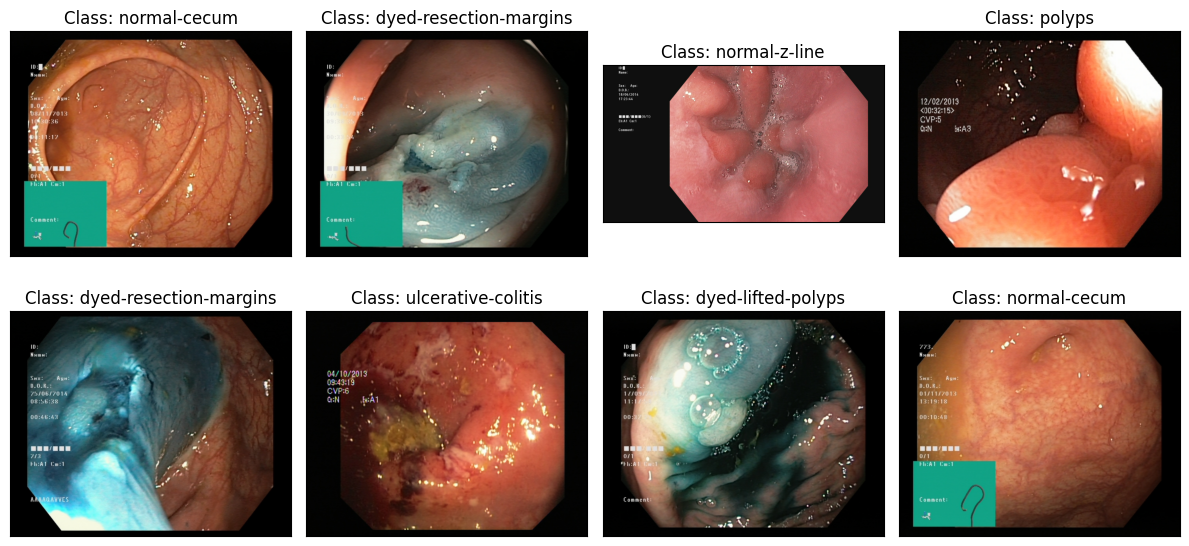

In [ ]:
plot_random_images('/content/kvasir-dataset/kvasir-dataset-v2')

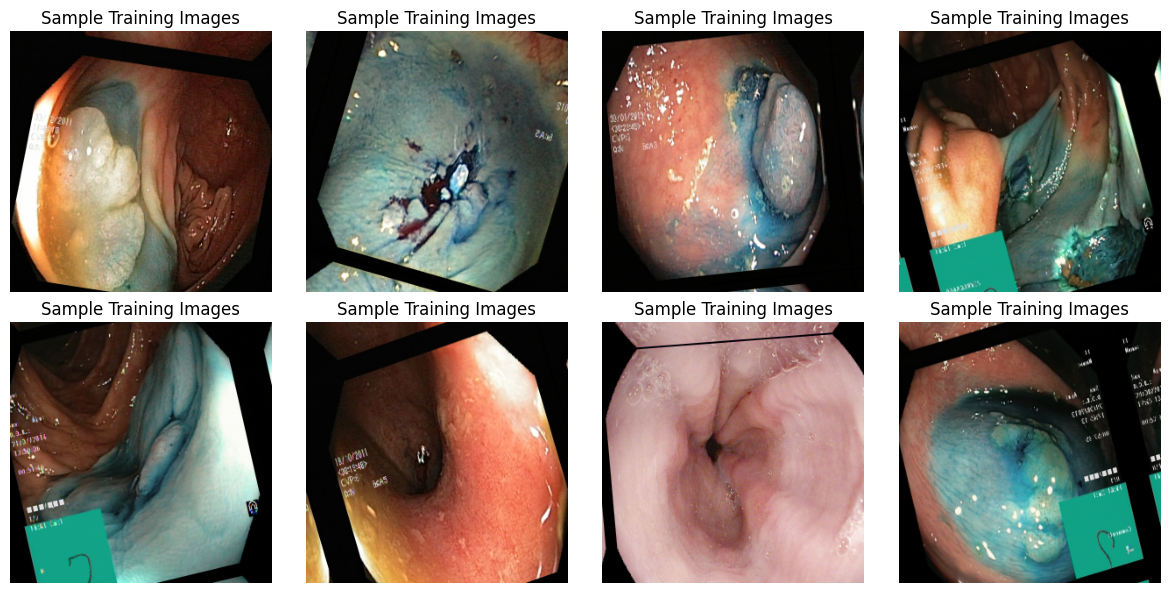

In [ ]:
plot_sample_images(train_data, "Sample Training Images")


######Model 1 - Custom CNN (Baseline)
######Define a basic CNN architecture.
######Train it for 10-15 epochs.
######Save accuracy & loss graphs.
######Evaluate on the validation set

In [ ]:
custom_model =Sequential([
    Conv2D(64, (3,4), activation='relu', input_shape=(299, 299, 3)),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])


custom_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_cnn = custom_model.fit(train_data, epochs=15, validation_data=val_data)


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.3181 - loss: 3.2874 - val_accuracy: 0.5706 - val_loss: 0.9058
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.5508 - loss: 0.9922 - val_accuracy: 0.5856 - val_loss: 0.8931
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.5861 - loss: 0.8670 - val_accuracy: 0.5831 - val_loss: 0.9192
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.6189 - loss: 0.8337 - val_accuracy: 0.7038 - val_loss: 0.6545
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.6571 - loss: 0.7385 - val_accuracy: 0.6087 - val_loss: 0.8099
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.6650 - loss: 0.7187 - val_accuracy: 0.7031 - val_loss: 0.6536
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.6855 - loss: 0.6802 - val_accuracy: 0.6938 - val_loss: 0.6347
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.6764 - loss: 0.6827 - val_accu

In [ ]:
custom_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 297, 297, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 148, 148, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 146, 146, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 73, 73, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 71, 71, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 35, 35, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 313600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │     160,563,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 482,815,898 (1.80 GB)

 Trainable params: 160,938,632 (613.93 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 321,877,266 (1.20 GB)

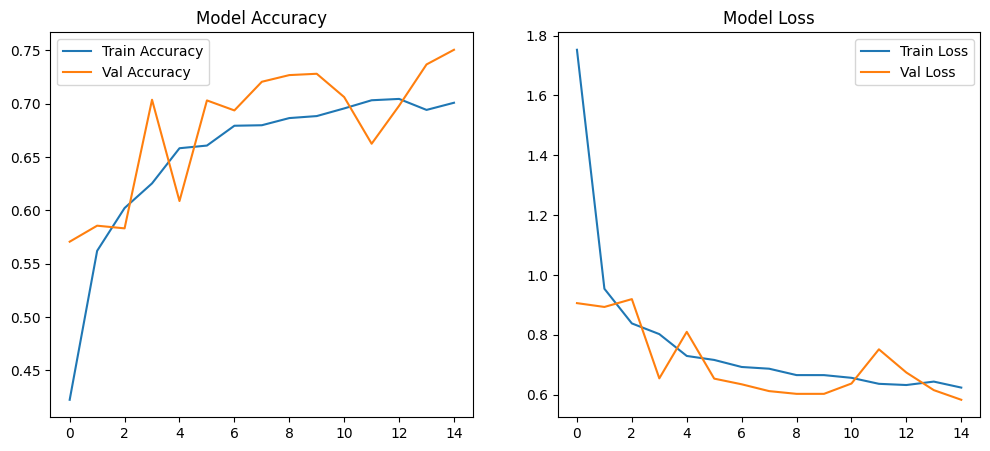

In [ ]:
plot_training(history_cnn)

In [ ]:
y_pred = np.argmax(custom_model.predict(val_data), axis=1)
y_true = val_data.classes
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

NameError: name 'custom_model' is not defined

In [ ]:
custom_model.save('custom_model.h5')

######Model 2 - Transfer Learning with InceptionV3
######Load pretrained InceptionV3 (without fully connected layers).
######Add custom classifier layers.
######Train for 15 epochs.
######Evaluate & compare with the custom CNN


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2025-03-06 20:17:23--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.207, 142.250.107.207, 108.177.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   145MB/s    in 0.6s    

2025-03-06 20:17:23 (145 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
pretrained_model= InceptionV3(
    input_shape=(299,299,3),
    include_top=False,
    weights=None
)
pretrained_model.load_weights('/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
pretrained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
last_layer = pretrained_model.get_layer('mixed7')
last_output = last_layer.output
x = Flatten()(last_output)
x = Dense(1024, activation='relu', kernel_regularizer=l2( 0.001))(x)
x = BatchNormalization()(x)
x= Dropout(0.35)(x)
x=Dense(8,activation='softmax')(x)
model = Model(pretrained_model.input,x)

optimizer = RMSprop(learning_rate= 0.00002, clipvalue=1.0)

model.compile(loss='categorical_crossentropy',optimizer= optimizer,metrics=['accuracy'])

history_transfer = model.fit(train_data,epochs=20,validation_data=val_data)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.5637 - loss: 3.4285 - val_accuracy: 0.8025 - val_loss: 2.6149
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.8248 - loss: 2.5462 - val_accuracy: 0.8306 - val_loss: 2.5515
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.8537 - loss: 2.4315 - val_accuracy: 0.8656 - val_loss: 2.4407
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.8663 - loss: 2.3675 - val_accuracy: 0.8981 - val_loss: 2.2597
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.8883 - loss: 2.2368 - val_accuracy: 0.8963 - val_loss: 2.2786
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.9002 - loss: 2.1870 - val_accuracy: 0.8906 - val_loss: 2.2741
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.9064 - loss: 2.1133 - val_accuracy: 0.9062 - val_loss: 2.1363
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.9117 - loss: 2.0887 - val_accu

In [ ]:
model.save('best_model.h5')


In [ ]:
plot_training(history_transfer)

In [ ]:
sample_image_path = "/content/kvasir-dataset/kvasir-dataset-v2/dyed-lifted-polyps/008aa3ed-1812-4854-954c-120ae85bb6bd.jpg"
heatmap = generate_gradcam(sample_image_path, model, last_conv_layer_name="mixed7")
overlay_gradcam(sample_image_path, heatmap)

NameError: name 'generate_gradcam' is not defined

In [ ]:
y_pred = np.argmax(model.predict(val_data), axis=1)
y_true = val_data.classes
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



##### Model Evaluation & Grad-CAM
#####	Compute confusion matrix and classification report.
##### Compute Confusion Matrix

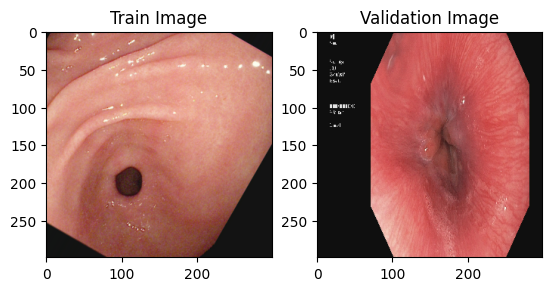

In [ ]:
import matplotlib.pyplot as plt

train_img, _ = train_data[0]  # First batch from train
val_img, _ = val_data[0]  # First batch from validation

plt.subplot(1, 2, 1)
plt.imshow(train_img[0])
plt.title("Train Image")

plt.subplot(1, 2, 2)
plt.imshow(val_img[0])
plt.title("Validation Image")

plt.show()


In [ ]:
pretrained_model = InceptionV3(
    input_shape=(299, 299, 3),
    include_top=False,
    weights=None
)
pretrained_model.load_weights('/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

for layer in pretrained_model.layers:
    if "mixed7" in layer.name or "mixed8" in layer.name or "mixed9" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

last_layer = pretrained_model.get_layer('mixed7')
last_output = last_layer.output

x = Flatten()(last_output)
x = Dense(1024, activation='relu', kernel_regularizer='l2')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(8, activation='softmax')(x)

model = Model(pretrained_model.input, x)

optimizer = Adam(learning_rate=1e-4)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(),
    metrics=["accuracy", Precision(), Recall(), AUC()]
)

history_transfer = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[reduce_lr])


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 655ms/step


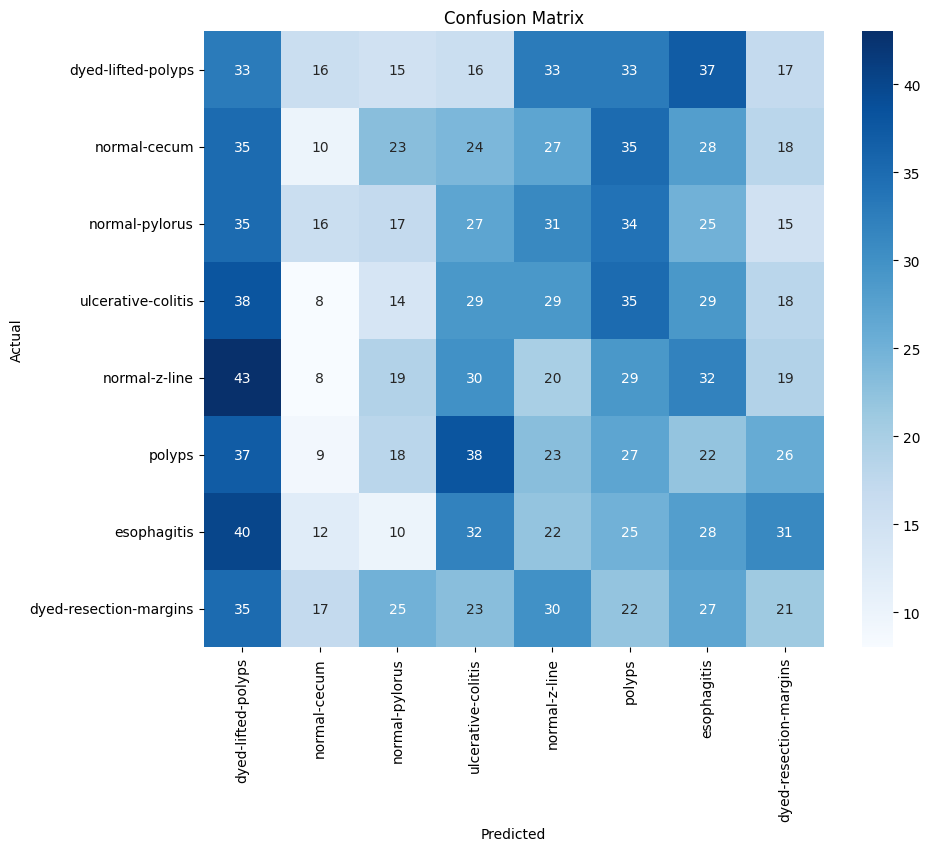

In [ ]:
y_pred = np.argmax(model.predict(val_data), axis=1)
y_true = val_data.classes
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import os
import random
import shutil

!wget https://datasets.simula.no/downloads/kvasir/kvasir-dataset-v2.zip
!unzip -q kvasir-dataset-v2.zip -d kvasir-dataset

data_dir = "kvasir-dataset/kvasir-dataset-v2"
validation_split = 0.2
random_seed = 42

class_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
print(f" Dataset contains {len(class_names)} classes: {class_names}")

val_dir = "validation"
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
    for class_name in class_names:
        os.makedirs(os.path.join(val_dir, class_name))

random.seed(random_seed)
for class_name in class_names:
    source_dir = os.path.join(data_dir, class_name)
    dest_dir = os.path.join(val_dir, class_name)
    image_files = os.listdir(source_dir)
    random.shuffle(image_files)

    num_val_samples = int(len(image_files) * validation_split)
    val_files = image_files[:num_val_samples]

    for file in val_files:
        source_path = os.path.join(source_dir, file)
        dest_path = os.path.join(dest_dir, file)
        shutil.move(source_path, dest_path)

--2025-06-27 15:03:20--  https://datasets.simula.no/downloads/kvasir/kvasir-dataset-v2.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2489312085 (2.3G) [application/zip]
Saving to: ‘kvasir-dataset-v2.zip’

kvasir-dataset-v2.z 100%[===================>]   2.32G  26.0MB/s    in 91s     

2025-06-27 15:04:52 (26.1 MB/s) - ‘kvasir-dataset-v2.zip’ saved [2489312085/2489312085]

 Dataset contains 8 classes: ['dyed-resection-margins', 'esophagitis', 'dyed-lifted-polyps', 'polyps', 'normal-pylorus', 'ulcerative-colitis', 'normal-cecum', 'normal-z-line']


In [ ]:
import os
import random
import shutil

!wget https://datasets.simula.no/downloads/kvasir/kvasir-dataset-v2.zip
!unzip -q kvasir-dataset-v2.zip -d kvasir-dataset

data_dir = "kvasir-dataset/kvasir-dataset-v2"
validation_split = 0.2
random_seed = 42

class_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
print(f" Dataset contains {len(class_names)} classes: {class_names}")

val_dir = "validation"
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
    for class_name in class_names:
        os.makedirs(os.path.join(val_dir, class_name))

random.seed(random_seed)
for class_name in class_names:
    source_dir = os.path.join(data_dir, class_name)
    dest_dir = os.path.join(val_dir, class_name)
    image_files = os.listdir(source_dir)
    random.shuffle(image_files)

    num_val_samples = int(len(image_files) * validation_split)
    val_files = image_files[:num_val_samples]

    for file in val_files:
        source_path = os.path.join(source_dir, file)
        dest_path = os.path.join(dest_dir, file)
        shutil.move(source_path, dest_path)